In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, log_loss, roc_curve, auc, confusion_matrix
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

2023-09-24 17:38:53.658635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initialize TPU

In [14]:
import warnings

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        if any("already been initialized" in str(warn.message) for warn in w):
            print("TPU was already initialized. Continuing.")
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    tpu_strategy = tf.distribute.get_strategy()
    print('No TPU found. Running on GPU/CPU.')

No TPU found. Running on GPU/CPU.


# Analyze data

In [3]:
train_dir = "./data/Training"
test_dir = "./data/Testing/"

In [4]:
# See data stats
skin = os.listdir(train_dir)
num_train = {}

for d in skin:
    if not d == '.DS_Store':
        num_train[d] = len(os.listdir(train_dir + '/' + d))

img_per_class_train = pd.DataFrame(num_train.values(), index=num_train.keys(), columns=["No. of images"])

img_per_class_train

,No. of images
no_tumor,395
meningioma_tumor,822
glioma_tumor,826
pituitary_tumor,827


<Axes: title={'center': 'Data distribution by disease'}, xlabel='Skin cancer classification', ylabel='Number of images'>

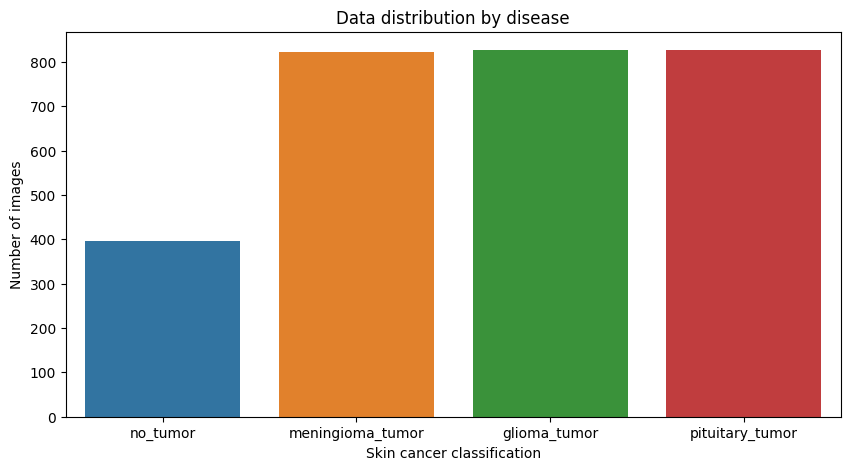

In [5]:
# Plot distribution
plt.figure(figsize=(10,5))

plt.title("Data distribution by disease")
plt.ylabel("Number of images")
plt.xlabel("Skin cancer classification")

keys = list(num_train.keys())
vals = list(num_train.values())

sns.barplot(x=keys, y=vals)

## See sample data

In [9]:
batch_size = 32
img_height = 300
img_width = 300

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


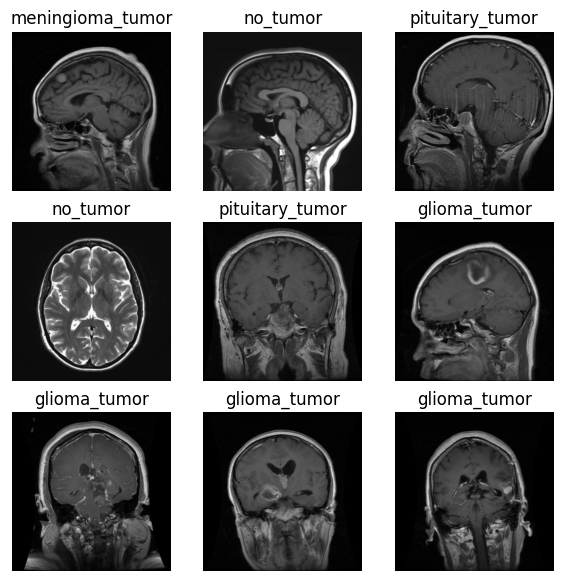

In [12]:
# Show images

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Normalize data

In [13]:
# To standarize RGB values from 0-255 to 0-1
# This layer will be used directly in the model
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Optimize dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [15]:
def augment(img, label):
    img = preprocessing.RandomFlip('horizontal')(img)
    img = preprocessing.RandomRotation(0.2)(img)
    img = preprocessing.RandomZoom(0.2)(img)
    return img, label

# Build model

In [16]:
num_classes = len(class_names)

def base_model():
    """
    Model 1: Basic model
    ---------------------
    - A simple CNN with 3 convolutional blocks followed by two dense layers.
    """
    train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

    return tf.keras.Sequential([
        normalization_layer,
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])


def model_with_extra_layers():
    """
    Model 2: Base + Additional Layers
    -----------------------------------------------------
    - Builds upon Model 1 by adding:
      - Leaky ReLU activations
      - Batch normalization
      - A larger convolutional layer
      - Global average pooling
"""
    train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

    return tf.keras.Sequential([
        normalization_layer,
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, (3,3), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(32, (3,3), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(64, (5,5), padding="same", activation="relu"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])

## Build model and set hyperparameters

In [ ]:
epochs = 200
model_num = 2

with tpu_strategy.scope():
    if model_num == 1:
        model = base_model()
    elif model_num == 2:
        model = model_with_extra_layers()

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

# Run model

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=20)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop])

# Validate model

In [ ]:
epochs_executed = len(history.history['loss'])
if (epochs_executed != epochs):
    graph_dir = 'graphs/Model ' + str(model_num) + '/' + str(epochs_executed) + ' (' + str(epochs) + ') epochs/'
else:
    graph_dir = 'graphs/Model ' + str(model_num) + '/' + str(epochs_executed) + ' epochs/'

if not os.path.exists(graph_dir):
    os.makedirs(graph_dir)

## Accuracy and loss

In [ ]:
epochs_range = range(epochs_executed)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs_range, history.history['loss'],label="Train Loss")
plt.plot(epochs_range, history.history['val_loss'], label="Validation Loss")
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(epochs_range, history.history['accuracy'], label="Train Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.ylim(0.75,1.0)
plt.legend()
plt.savefig(graph_dir + 'accuracy.png')
plt.tight_layout()

## Evaluate

In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation loss: {val_loss:.4f}")

### F1 score, Recall and Log loss

# Convert logits to probabilities
y_pred_probs = tf.nn.softmax(model.predict(val_ds)).numpy()

# Get the class with the highest probability as predicted class
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract true labels from the validation dataset
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # 'weighted' can be replaced with 'micro', 'macro', etc. depending on the needs

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')  # similarly, 'weighted' can be replaced

# Calculate log loss
loss = log_loss(y_true, y_pred_probs)

print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Log Loss: {loss:.4f}")

### ROC & AUC

In [ ]:
# Extract true labels from the validation dataset
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:,1])

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(graph_dir + 'ROC.png')
plt.show()

# Write to CSV

In [ ]:
data_to_write = {
    'Model': model_num,
    'Epochs': epochs_executed,
    'Accuracy': val_accuracy,
    'Loss': val_loss,
    'F1 Score': f1,
    'Recall': recall,
    'Log loss': loss,
    'AUC': roc_auc
    
}
df_to_append = pd.DataFrame(data_to_write, index=[0]).round(3)

# Append/Create CSV
csv_file = 'results.csv'
if not os.path.isfile(csv_file):
    df_to_append.to_csv(csv_file, header=True, index=False)
else:
    df_to_append.to_csv(csv_file, mode='a', header=False, index=False)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, linecolor="black", linewidths=1, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig(graph_dir + 'confusion.png')
    plt.show()

# Example usage:
# Assuming test_data.classes contains the true labels and y_pred contains the predicted labels
plot_confusion_matrix(y_true, y_pred, class_names)

# Plot the models

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='graphs/Model ' + str(model_num) + '/model.png', show_shapes=True, show_layer_names=True)

# Save the model

In [ ]:
filename = 'model ' + str(model_num) + ' (' + str(epochs_executed) + ') epochs'
model.save(filename + '.h5')
model.save(filename, save_format='tf')